# SARSA On-Policy Control

We will be using **TD control method of SARSA** on Cliff World environment as given below:  

![GridWorld](./images/cliffworld.png "Cliff World")


### SARSA On-Policy control

SARSA control is carried out by sampling step by step and updating Q values at each step. This leads to continuous improvement of ε-greedy policy. The Update equation is given below:

$$ Q(S,A) \leftarrow Q(S,A) + \alpha * [ R + \gamma * Q(S’,A’) – Q(S,A)] $$



In [14]:
# Initial imports and environment setup
import gymnasium as gym
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# SARSA Learning agent class
from collections import defaultdict


class SARSAAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))

    def get_Q(self, state, action):
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        self._Q[state][action] = value

    # carryout SARSA updated based on the sample (S, A, R, S', A')
    def update(self, state, action, reward, next_state, next_action, done):
        if not done:
            td_error = reward + \
                       self.gamma * self.get_Q(next_state, next_action) - \
                       self.get_Q(state, action)
        else:
            td_error = reward - self.get_Q(state, action)

        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    # get argmax for q(s,a)
    def max_action(self, state):
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    # choose action as per epsilon-greedy policy
    def get_action(self, state):
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [16]:
# training algorithm
def train_agent(env, agent, episode_cnt=10000, tmax=10000, anneal_eps=True):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state, _ = env.reset()
        action = agent.get_action(state)
        for t in range(tmax):
            next_state, reward, done, _, _ = env.step(action)
            next_action = agent.get_action(next_state)
            agent.update(state, action, reward, next_state, next_action, done)
            G += reward
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period.
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            state = next_state
            action = next_action
    return np.array(episode_rewards)

In [17]:
# plot rewards
def plot_rewards(env_name, rewards, label):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name,
                                                    np.mean(rewards[-20:])))
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-300, 0)
    plt.show()

In [25]:
# helper function to print policy under Cliff world
def print_policy(env, agent):

    _cliff = np.zeros(env.shape, dtype=bool)
    _cliff[3, 1:-1] = True    
    nR, nC = _cliff.shape

    actions = '^>v<'

    for y in range(nR):
        for x in range(nC):
            if _cliff[y, x]:
                print(" C ", end='')
            elif (y * nC + x) == env.start_state_index:
                print(" X ", end='')
            elif (y * nC + x) == nR * nC - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.max_action(y * nC + x)], end='')
        print()

In [19]:
# create cliff world environment
env = gym.make("CliffWalking-v0", render_mode="human")

In [20]:
# create a SARSA agent
agent = SARSAAgent(
            alpha=0.25,
            epsilon=0.2,
            gamma=0.99,
            get_possible_actions=lambda s : range(env.nA)
        )

#train agent and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt = 5000)

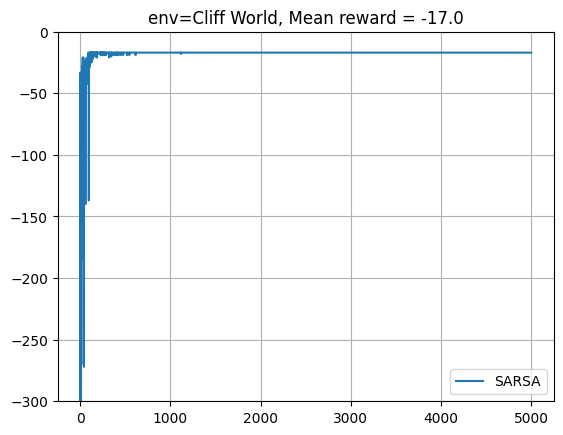

In [21]:
# plot rewards
plot_rewards("Cliff World",rewards, 'SARSA')

In [26]:
# print policy
print_policy(env, agent)

 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  ^  >  >  >  ^  >  v 
 ^  ^  >  ^  ^  ^  ^  <  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


### SARSA On-Policy for "Taxi" environment 

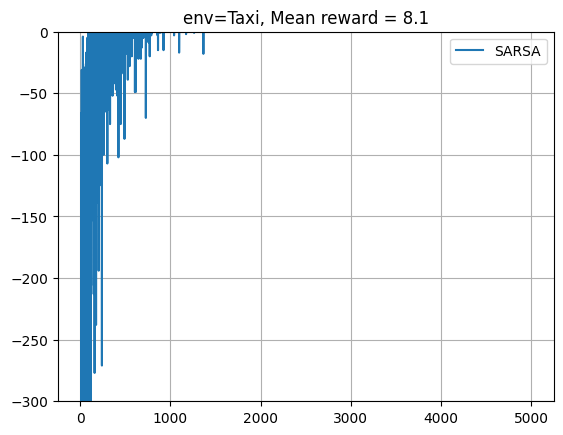

In [29]:
# create taxi environment
env = gym.make("Taxi-v3", render_mode="rgb_array")

# create a SARSA agent
agent = SARSAAgent(
            alpha=0.25, 
            epsilon=0.2, 
            gamma=0.99, 
            get_possible_actions=lambda s : range(env.action_space.n)
        )

#train agent and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt = 5000)

#plot reward graph
plot_rewards("Taxi", rewards, 'SARSA')

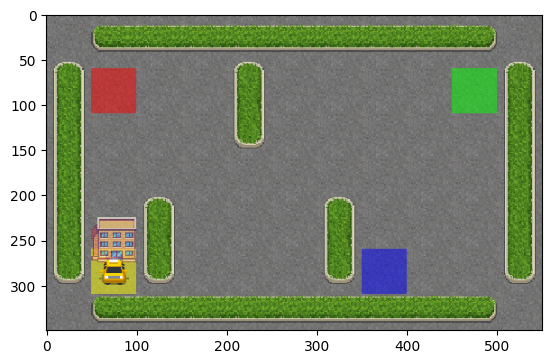

In [30]:
plt.imshow(env.render())

### Conclusion

We see that SARSA agent learns the optimal policy by end of 500 episodes of training. The policy learnt is to avoid the cliff by first going all the way up and then taking a right turn to walk towards the goal. This is surprising as we would have expected the agent to learn the policy to skirt over the cliff and reach goal which would have been the shortest path, a path shorter by 4 steps as compared to the one learnt by agent. 

However, as our policy continues to explore using ε-greedy, there is always a small chance that agent when next to a cliff cell, takes a random action and falls into the cliff. It demonstrates the issue of continued exploration even when enough has been learnt about the environment i.e. when same ε-greedy policy is used for sampling as well for improvement. 